# Using vector data

<div>
    <img style='width: 220px;height: 100px;float: left;' src="./Supplementary_data/EODC-Logo-Final.png" height='100px' width='220px'/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/BMNT_DE_Logo_dreizeilig_srgb.svg" height='100px' width='200px'/> 
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/bmlv.svg" height='100px' width='200px'/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/LOGO_TUW_GEO.png" height='100px' width='200px'/>
    <img style='width: 100px;height: 100px;float: left;' src="./Supplementary_data/Boku-wien.svg" height='100px' width='100px'/>
    <img style='width: 150px;height: 100px;float: right;' src="./Supplementary_data/ADC_Logo_final_transparent.png" height='100px' width='150px'/>
</div>

This notebook shows how to use vector data for querying and for masking the data, limiting only to selected polygons. The shapefile is located in `./Supplementary_data/shapefiles/Betrieb_H.shp`

**NOTE:** It is necessary to install geopandas in the datacube environment and upload the shapefiles to a folder called `shapefiles` which should be located in the same folder where the notebook is uploaded. 

To install geopandas open a New Launcher (denoted by the + icon in the top left of the app, under the Edit menu) and select Terminal option at the bottom of the launcher window.

In the Terminal you need to run two commands:
```shell
source activate datacube
conda install -y geopandas decartes
```

The installation may take some time, but after finishing the Terminal may be closed.

In [1]:
import geopandas
import datacube
from datacube import helpers
from datacube.utils import geometry
import fiona
import rasterio.features
import xarray
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=15)
acube = datacube.Datacube(app='sample_4', env='acube')

## Load Polygons

The function `load_polygon` extracts geopolygon for usage in the `datacube` query and pfeature which is used by `rasterio` for the mask.

In [2]:
def load_polygon(shape_file):
    with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        return geometry.Geometry(first_geometry, crs=crs), geopandas.read_file(shape_file)

In [3]:
geopolygon_h, pfeature_h = load_polygon('./Supplementary_data/shapefiles/Betrieb_H.shp')

## Define the query for desired polygon

The example shows polygon H being used. For using different geopolygons modify the code below

In [4]:
polygon = geopolygon_h
masking_feature = pfeature_h['geometry']
filename = 'LAI_POLYGON_M'
query = {
    'time': ('2017-03-01', '2017-10-31'),
    'product': 'LAI_Sentinel_2',
    'geopolygon': polygon,
    'output_crs': 'EPSG:32633',
    'resolution': (-10, 10)
}

<AxesSubplot:>

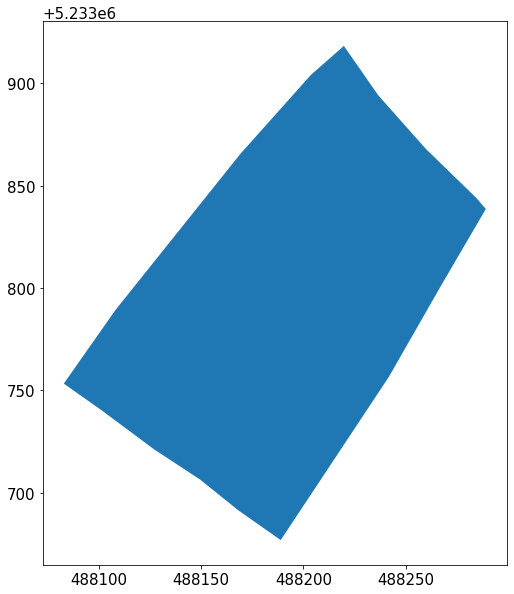

In [5]:
masking_feature.plot(figsize=(10, 10))

## Load Data

The following load function uses the defined geopolygon for querying, meaning the shapefile will be used for the query instead of the `lat` and `lon`.

In [6]:
data = acube.load(**query)
data

<xarray.Dataset>
Dimensions:      (time: 79, x: 21, y: 25)
Coordinates:
  * time         (time) datetime64[ns] 2017-03-05 2017-03-09 ... 2017-10-31
  * y            (y) float64 5.234e+06 5.234e+06 ... 5.234e+06 5.234e+06
  * x            (x) float64 4.881e+05 4.881e+05 ... 4.883e+05 4.883e+05
    spatial_ref  int32 32633
Data variables:
    band_1       (time, y, x) int16 32767 32767 32767 ... 32767 32767 32767
Attributes:
    crs:           EPSG:32633
    grid_mapping:  spatial_ref

## Visualize Data

We can use `rasterio` to create a mask to mask out all the data outside of the polygon.

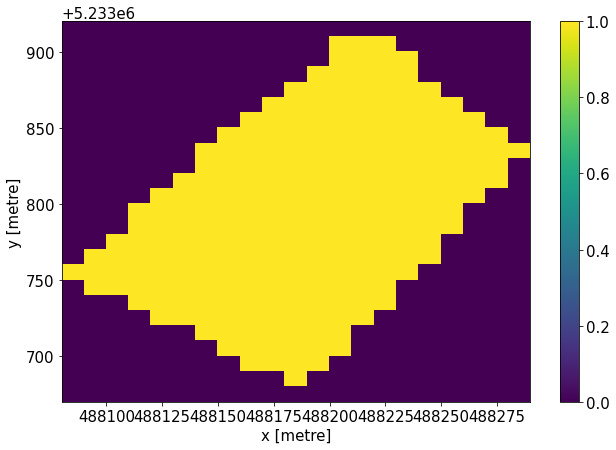

In [7]:
data_plot = data.band_1.where(data.band_1 != data.band_1.attrs['nodata']).dropna(dim='time')
mask = rasterio.features.rasterize(masking_feature,
                                   out_shape=data.isel(time=0).band_1.shape,
                                   transform=data.band_1.affine)
mask = xarray.DataArray(mask, coords=(data.y, data.x))
mask.plot(size=7)

The code for plotting below can be modified to display a different scale of values with the parameters `vmax` and `vmin`

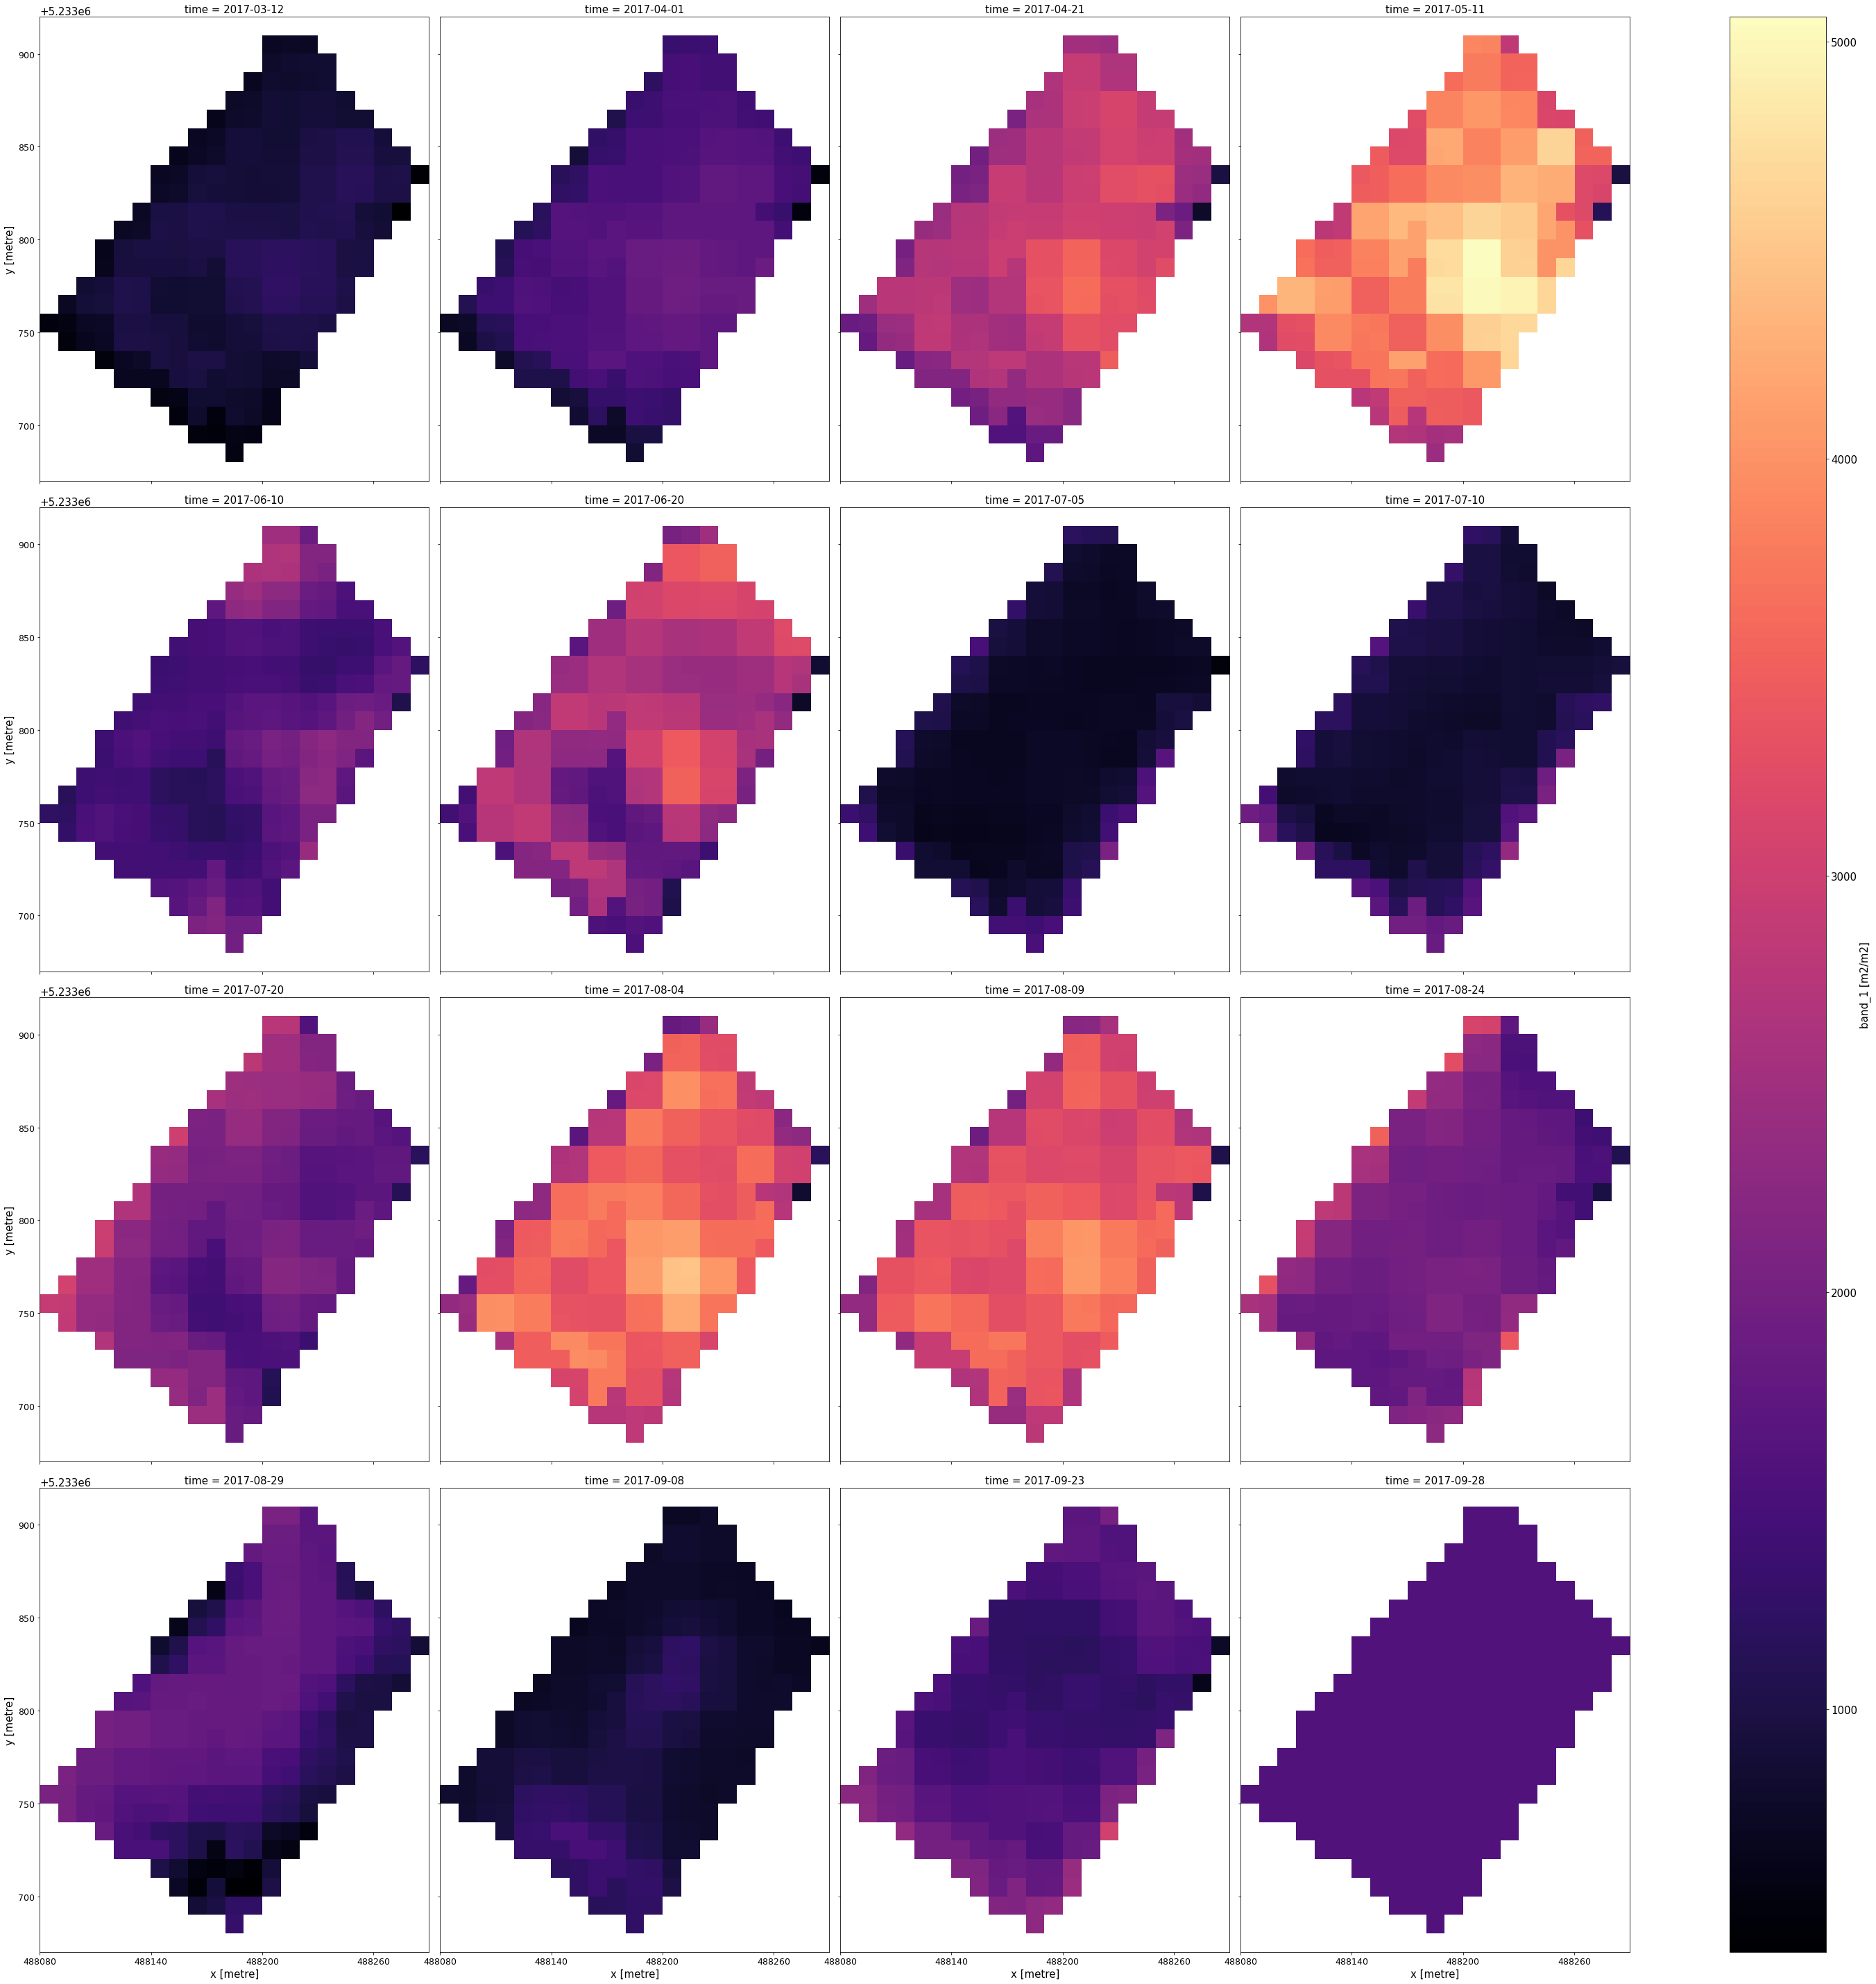

In [9]:
masked_data = data_plot.where(mask)
imshowfig = masked_data.plot.imshow(x='x', 
                        y='y',
                        col='time',
                        size=10,
                        col_wrap=4,
                        cmap='magma',
                        add_colorbar=True)#, vmax=3534, vmin=746)
imshowfig.set_ticks(max_xticks=4)